In [1]:

!pip install opacus
import torch
from torchvision import datasets, transforms
import numpy as np
from opacus import PrivacyEngine
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
from numpy import vstack
from numpy import argmax
from sklearn.metrics import accuracy_score


# importing training dataset which has 60,000 observation
train_loader = torch.utils.data.DataLoader(datasets.MNIST('../mnist', train=True, download=True,
                                                          transform=transforms.Compose(
                                                              [transforms.ToTensor(), transforms.Normalize((0.1307,),
                                                                                                           (
                                                                                                           0.3081,)), ]), ),
                                           batch_size=64, shuffle=True, num_workers=1, pin_memory=True)

# importing testing dataset which has 10,000 observation
test_loader = torch.utils.data.DataLoader(datasets.MNIST('../mnist', train=False,
                                                         transform=transforms.Compose(
                                                             [transforms.ToTensor(), transforms.Normalize((0.1307,),
                                                                                                          (
                                                                                                          0.3081,)), ]), ),
                                          batch_size=1024, shuffle=True, num_workers=1, pin_memory=True)

# Creating a PyTorch Neural Network Classification Model and Optimizer
model = torch.nn.Sequential(torch.nn.Conv2d(1, 16, 8, 2, padding=3), torch.nn.ReLU(), torch.nn.MaxPool2d(2, 1),
                            torch.nn.Conv2d(16, 32, 4, 2), torch.nn.ReLU(), torch.nn.MaxPool2d(2, 1),
                            torch.nn.Flatten(),
                            torch.nn.Linear(32 * 4 * 4, 32), torch.nn.ReLU(), torch.nn.Linear(32, 10))

optimizer = torch.optim.SGD(model.parameters(), lr=0.05)



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 176 kB 8.0 MB/s 


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../mnist/MNIST/raw/train-images-idx3-ubyte.gz to ../mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ../mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ../mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../mnist/MNIST/raw



In [2]:
# Training a model without adding a noise
def train_notprivate(model, train_loader, optimizer, epoch, device):
    model.train()
    criterion = torch.nn.CrossEntropyLoss()
    losses = []
    for _batch_idx, (data, target) in enumerate(tqdm(train_loader)):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    print(
        f"Train Epoch: {epoch} \t"
        f"Loss: {np.mean(losses):.6f} ")

for epoch in range(1, 11):
    train_notprivate(model, train_loader, optimizer, epoch, device="cpu")

100%|██████████| 938/938 [00:23<00:00, 39.54it/s]


Train Epoch: 1 	Loss: 0.290207 


100%|██████████| 938/938 [00:23<00:00, 40.24it/s]


Train Epoch: 2 	Loss: 0.068482 


100%|██████████| 938/938 [00:24<00:00, 37.76it/s]


Train Epoch: 3 	Loss: 0.050536 


100%|██████████| 938/938 [00:23<00:00, 40.14it/s]


Train Epoch: 4 	Loss: 0.040364 


100%|██████████| 938/938 [00:24<00:00, 38.38it/s]


Train Epoch: 5 	Loss: 0.033600 


100%|██████████| 938/938 [00:23<00:00, 40.66it/s]


Train Epoch: 6 	Loss: 0.028860 


100%|██████████| 938/938 [00:23<00:00, 40.44it/s]


Train Epoch: 7 	Loss: 0.025450 


100%|██████████| 938/938 [00:23<00:00, 40.29it/s]


Train Epoch: 8 	Loss: 0.021380 


100%|██████████| 938/938 [00:23<00:00, 40.58it/s]


Train Epoch: 9 	Loss: 0.018919 


100%|██████████| 938/938 [00:23<00:00, 40.51it/s]

Train Epoch: 10 	Loss: 0.017076 


In [3]:
# Evaluating a model accuracy
def evaluate_model(test_dl, model):
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_dl):
      # evaluate the model on the test set
      yhat = model(inputs)
      # retrieve numpy array
      yhat = yhat.detach().numpy()
      actual = targets.numpy()
      # convert to class labels
      yhat = argmax(yhat, axis=1)
      # reshape for stacking
      actual = actual.reshape((len(actual), 1))
      yhat = yhat.reshape((len(yhat), 1))
      # store
      predictions.append(yhat)
      actuals.append(actual)
    predictions, actuals = vstack(predictions), vstack(actuals)
    # calculate accuracy
    acc = accuracy_score(actuals, predictions)
    return acc
 

# prepare the data
train_dl, test_dl = train_loader, test_loader
print(len(train_dl.dataset), len(test_dl.dataset))
acc = evaluate_model(test_dl, model)
print('Accuracy: %.3f' % acc)

60000 10000
Accuracy: 0.988


In [36]:
# Creating a PyTorch Neural Network Classification Model and Optimizer
DP_model = torch.nn.Sequential(torch.nn.Conv2d(1, 16, 8, 2, padding=3), torch.nn.ReLU(), torch.nn.MaxPool2d(2, 1),
                            torch.nn.Conv2d(16, 32, 4, 2), torch.nn.ReLU(), torch.nn.MaxPool2d(2, 1),
                            torch.nn.Flatten(),
                            torch.nn.Linear(32 * 4 * 4, 32), torch.nn.ReLU(), torch.nn.Linear(32, 10))

DP_optimizer = torch.optim.SGD(DP_model.parameters(), lr=0.05)

# Attaching a Differential Privacy Engine to the Optimizer
privacy_engine= PrivacyEngine()
N_model, N_optimizer, dataloader = privacy_engine.make_private(
    module=DP_model,
    optimizer=DP_optimizer,
    data_loader=train_loader,
    noise_multiplier=1.3,
    max_grad_norm=1.1,
    poisson_sampling=False,
)


def get_epsilon(self, delta):
  return self.accountant.get_epsilon(delta)
# Training the private model over multiple epochs
def train(model, train_loader, optimizer, epoch, device, delta):
    model.train()
    criterion = torch.nn.CrossEntropyLoss()
    losses = []
    for _batch_idx, (data, target) in enumerate(tqdm(train_loader)):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    epsilon=privacy_engine.get_epsilon(delta)
    print(
        f"Train Epoch: {epoch} \t"
        f"Loss: {np.mean(losses):.6f} "
        f"(ε = {epsilon:.2f}, δ = {delta})")

for epoch in range(1, 11):
    train(N_model, dataloader, N_optimizer, epoch, device="cpu", delta=1e-5)


/usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:131: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  "Secure RNG turned off. This is perfectly fine for experimentation as it allows "
  0%|          | 0/938 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1033: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
100%|██████████| 938/938 [00:38<00:00, 24.33it/s]


Train Epoch: 1 	Loss: 1.119880 (ε = 0.36, δ = 1e-05)


100%|██████████| 938/938 [00:38<00:00, 24.47it/s]


Train Epoch: 2 	Loss: 0.484659 (ε = 0.37, δ = 1e-05)


100%|██████████| 938/938 [00:38<00:00, 24.09it/s]


Train Epoch: 3 	Loss: 0.477142 (ε = 0.38, δ = 1e-05)


100%|██████████| 938/938 [00:39<00:00, 23.46it/s]


Train Epoch: 4 	Loss: 0.466827 (ε = 0.39, δ = 1e-05)


100%|██████████| 938/938 [00:38<00:00, 24.34it/s]


Train Epoch: 5 	Loss: 0.453466 (ε = 0.40, δ = 1e-05)


100%|██████████| 938/938 [00:39<00:00, 23.88it/s]


Train Epoch: 6 	Loss: 0.487191 (ε = 0.41, δ = 1e-05)


100%|██████████| 938/938 [00:39<00:00, 23.88it/s]


Train Epoch: 7 	Loss: 0.506258 (ε = 0.42, δ = 1e-05)


100%|██████████| 938/938 [00:39<00:00, 23.98it/s]


Train Epoch: 8 	Loss: 0.514731 (ε = 0.43, δ = 1e-05)


100%|██████████| 938/938 [00:40<00:00, 23.34it/s]


Train Epoch: 9 	Loss: 0.581342 (ε = 0.44, δ = 1e-05)


100%|██████████| 938/938 [00:46<00:00, 20.17it/s]


Train Epoch: 10 	Loss: 0.654301 (ε = 0.45, δ = 1e-05)


In [37]:
acc = evaluate_model(test_loader, N_model)
print('Accuracy: %.3f' % acc)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1033: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Accuracy: 0.920


In [31]:
dataloader.batch_size
examples = enumerate(dataloader)
batch_idx, (example_data, example_targets) = next(examples)

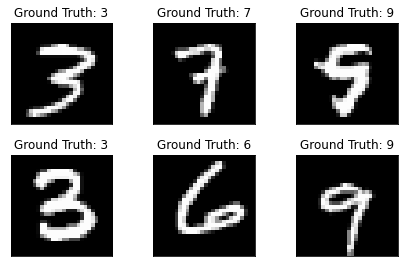

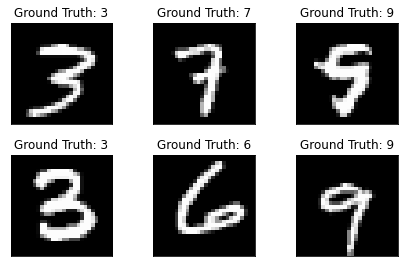

In [32]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [33]:
print(N_model)
model_child = list(N_model.children())


GradSampleModule(Sequential(
  (0): Conv2d(1, 16, kernel_size=(8, 8), stride=(2, 2), padding=(3, 3))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=512, out_features=32, bias=True)
  (8): ReLU()
  (9): Linear(in_features=32, out_features=10, bias=True)
))


In [34]:
import torch.nn as nn
no_of_layers=0
conv_layers=[]
for child in model_child:
  if type(child)==nn.Conv2d:
    no_of_layers+=1
    conv_layers.append(child)
  elif type(child)==nn.Sequential:
    for layer in child.children():
      if type(layer)==nn.Conv2d:
        no_of_layers+=1
        conv_layers.append(layer)

img = example_data
results = [conv_layers[0](img)]
for i in range(1, len(conv_layers)):
    results.append(conv_layers[i](results[-1]))
outputs = results

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1033: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


1


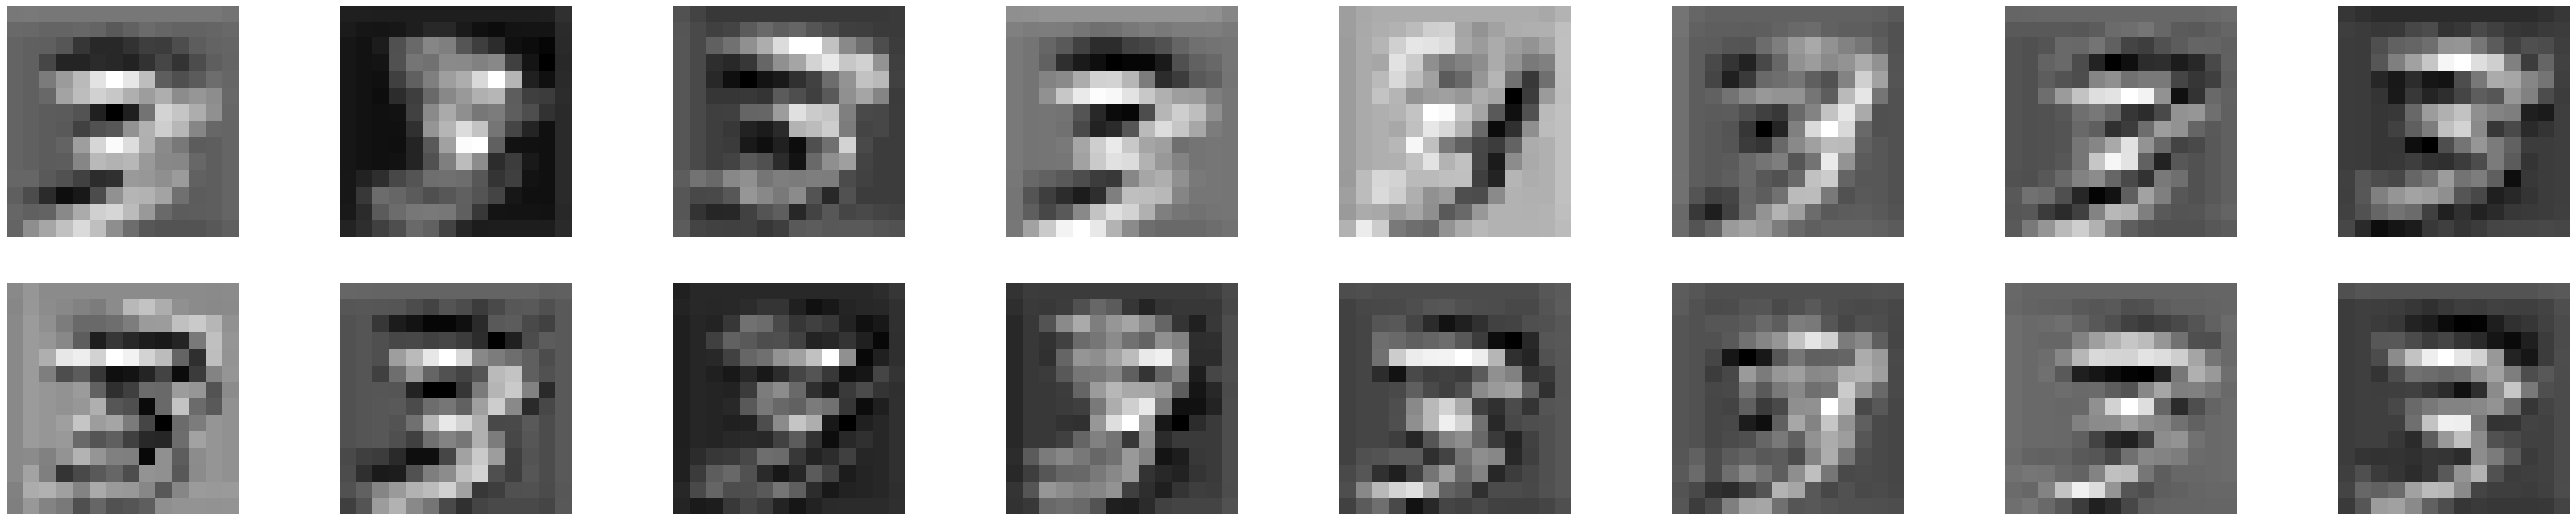

2


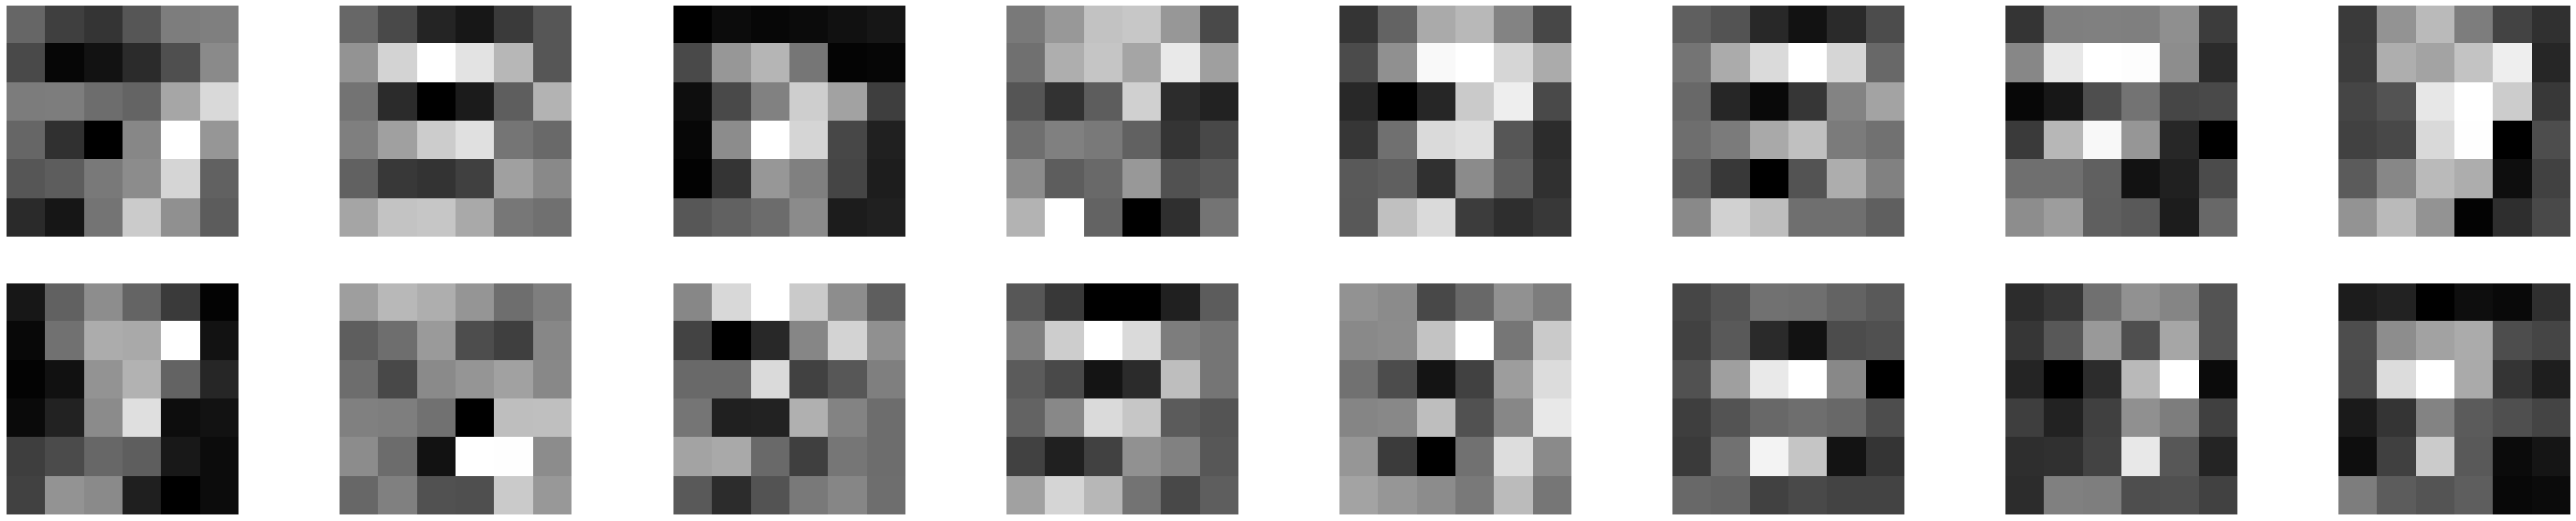

In [35]:
for num_layer in range(len(outputs)):
    plt.figure(figsize=(50, 10))
    layer_viz = outputs[num_layer][0, :, :, :]
    layer_viz = layer_viz.data
    print(num_layer+1)
    for i, filter in enumerate(layer_viz):
        if i == 16: 
            break
        plt.subplot(2, 8, i + 1)
        plt.imshow(filter, cmap='gray')
        plt.axis("off")
    plt.show()
    plt.close()